#### [[back to main](../week_05_geospatial_data.ipynb)]

<p><font size="6"><b>Coordinate reference systems</b></font></p>

In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
world = gpd.read_file("../assets/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
cities = gpd.read_file("../assets/ne_110m_populated_places/ne_110m_populated_places.shp")
rivers = gpd.read_file("../assets/ne_50m_rivers_lake_centerlines/ne_50m_rivers_lake_centerlines.shp")

## Coordinate reference systems

Up to now, we have used the geometry data with certain coordinates without further wondering what those coordinates mean or how they are expressed.

> The **Coordinate Reference System (CRS)** relates the coordinates to a specific location on earth.

For an in-depth explanation, see https://docs.qgis.org/2.8/en/docs/gentle_gis_introduction/coordinate_reference_systems.html

### Geographic coordinates

> Degrees of latitude and longitude.
>
> E.g. 48°51′N, 2°17′E

The most known type of coordinates are geographic coordinates: we define a position on the globe in degrees of latitude and longitude, relative to the equator and the prime meridian. 
With this system, we can easily specify any location on earth. It is used widely, for example in GPS. If you inspect the coordinates of a location in Google Maps, you will also see latitude and longitude.

**Attention!**

in Python we use (lon, lat) and not (lat, lon)

- Longitude: [-180, 180]{{1}}
- Latitude: [-90, 90]{{1}}

### Projected coordinates

> `(x, y)` coordinates are usually in meters or feet

Although the earth is a globe, in practice we usually represent it on a flat surface: think about a physical map, or the figures we have made with Python on our computer screen.
Going from the globe to a flat map is what we call a *projection*.

![](../assets/projection.png)

We project the surface of the earth onto a 2D plane so we can express locations in cartesian x and y coordinates, on a flat surface. In this plane, we then typically work with a length unit such as meters instead of degrees, which makes the analysis more convenient and effective.

However, there is an important remark: the 3 dimensional earth can never be represented perfectly on a 2 dimensional map, so projections inevitably introduce distortions. To minimize such errors, there are different approaches to project, each with specific advantages and disadvantages.

Some projection systems will try to preserve the area size of geometries, such as the Albers Equal Area projection. Other projection systems try to preserve angles, such as the Mercator projection, but will see big distortions in the area. Every projection system will always have some distortion of area, angle or distance.

<table><tr>
<td> <img src="../assets/projections-AlbersEqualArea.png"/> </td>
<td> <img src="../assets/projections-Mercator.png"/> </td>
</tr>
<tr>
<td> <img src="../assets/projections-Robinson.png"/> </td>
</tr></table>

**Projected size vs actual size (Mercator projection)**:

![](../assets/mercator_projection_area.gif)

## Coordinate Reference Systems in Python / GeoPandas

A GeoDataFrame or GeoSeries has a `.crs` attribute which holds (optionally) a description of the coordinate reference system of the geometries:

In [3]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

For the `world` dataframe, it indicates that it uses the EPSG 4326 / WGS84 lon/lat reference system, which is one of the most used for geographic coordinates.


It uses coordinates as latitude and longitude in degrees, as can you be seen from the x/y labels on the plot:

<Axes: >

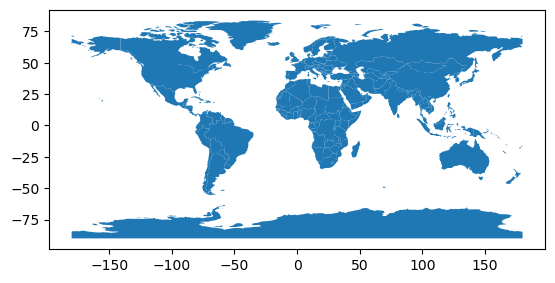

In [4]:
world.plot()

The `.crs` attribute returns a `pyproj.CRS` object. To specify a CRS, we typically use some string representation:


- **EPSG code**
  
  Example: `EPSG:4326` = WGS84 geographic CRS (longitude, latitude)
  
- **Well-Know-Text (WKT)** representation

- In older software and datasets, you might also encounter a "`proj4` string" representation:
  
  Example: `+proj=longlat +datum=WGS84 +no_defs`

  This is however no longer recommended.


See eg https://epsg.io/4326

Under the hood, GeoPandas uses the `pyproj` / `PROJ` libraries to deal with the re-projections.

For more information, see also http://geopandas.readthedocs.io/en/latest/projections.html.

### Transforming to another CRS

We can convert a GeoDataFrame to another reference system using the `to_crs` function. 

For example, let's convert the countries to the World Mercator projection (http://epsg.io/3395):

In [5]:
# remove Antartica, as the Mercator projection cannot deal with the poles
world = world[(world['name'] != "Antarctica")]

In [6]:
world_mercator = world.to_crs(epsg=3395)  # or .to_crs("EPSG:3395")

<Axes: >

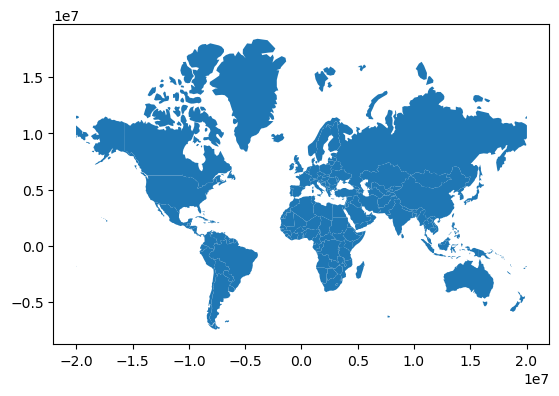

In [7]:
world_mercator.plot()

Note the different scale of x and y.

### Why using a different CRS?

There are sometimes good reasons you want to change the coordinate references system of your dataset, for example:

- Different sources with different CRS -> need to convert to the same crs

    ```python
    df1 = geopandas.read_file(...)
    df2 = geopandas.read_file(...)

    df2 = df2.to_crs(df1.crs)
    ```

- Mapping (distortion of shape and distances)

- Distance / area based calculations -> ensure you use an appropriate projected coordinate system expressed in a meaningful unit such as meters or feet (not degrees).

**ATTENTION:**

All the calculations that happen in GeoPandas and Shapely assume that your data is in a 2D cartesian plane, and thus the result of those calculations will only be correct if your data is properly projected.

# Areas, centroids and distances
Once we project properly, we can easily measure the area of polygons:

In [8]:
# Create a new column 'area' that is the area of each geometry (country)
world_mercator['area'] = world_mercator.area
world_mercator.sort_values('area', ascending=False)

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,area
135,RUS,Russia,Europe,1.422575e+08,3745000.00,"MULTIPOLYGON (((5408385.481 5103899.184, 53419...",8.293100e+13
27,CAN,Canada,North America,3.562368e+07,1674000.00,"MULTIPOLYGON (((-7087099.722 5837897.11, -7006...",5.209916e+13
65,GRL,Greenland,North America,5.771300e+04,2173.00,"POLYGON ((-5205721.29 17448319.152, -4831982.7...",3.627072e+13
168,USA,United States of America,North America,3.266258e+08,18560000.00,"MULTIPOLYGON (((-13674486.249 6242596, -133583...",2.179839e+13
30,CHN,China,Asia,1.379303e+09,21140000.00,"MULTIPOLYGON (((8366553.382 4431869.642, 83467...",1.491405e+13
...,...,...,...,...,...,...,...
172,VUT,Vanuatu,Oceania,2.828140e+05,723.00,"MULTIPOLYGON (((18684406.211 -1846685.56, 1864...",8.068921e+09
160,TTO,Trinidad and Tobago,North America,1.218208e+06,43570.00,"POLYGON ((-6866186.192 1196928.987, -6802177.4...",7.999410e+09
132,PSX,Palestine,Asia,4.543126e+06,21220.77,"POLYGON ((3940438.428 3674114.367, 3888101.327...",6.981457e+09
97,LUX,Luxembourg,Europe,5.941300e+05,58740.00,"POLYGON ((631632.574 6332662.055, 643695.764 6...",5.769606e+09


We can get the centre of the polygons:

<Axes: >

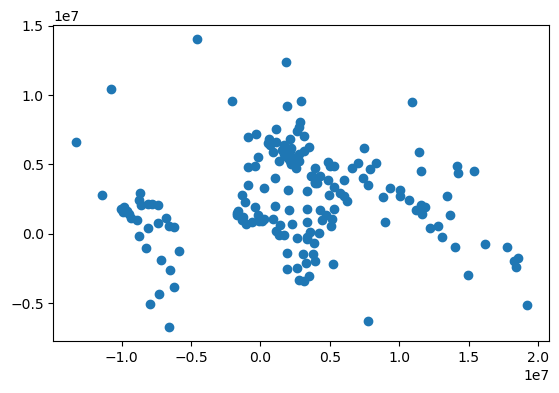

In [9]:
# Create a new column that is the centroid of each geometry (country)
world_mercator['centroid'] = world_mercator.centroid
world_mercator['centroid'].plot()

GeoPandas can handle multiple geometry types in different columns. If plotting the data frame then only one can be _active_, but no data is lost.

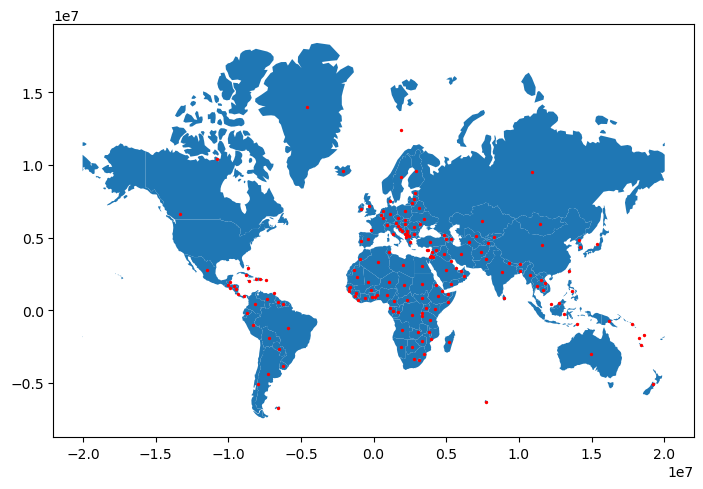

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,5))

world_mercator.geometry.plot(ax=ax)
world_mercator.centroid.plot(ax=ax, markersize=2, color='red')

plt.tight_layout()

We can calculate distances between these centroids, e.g., say we want to calculate the distance from the UK:

In [11]:
# Get the row that is for the UK
uk_centroid = world_mercator[world_mercator['name'] == 'United Kingdom']['centroid'].iloc[0]
# Create a new column and use the distance() method to calculate the distance to the UK centroid
world_mercator['distance_to_uk'] = world_mercator['centroid'].distance(uk_centroid)
world_mercator.sort_values('distance_to_uk', ascending=False)

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,area,centroid,distance_to_uk
120,NZL,New Zealand,Oceania,4510327.0,174800.0,"MULTIPOLYGON (((19260540.019 -4972415.778, 192...",4.986414e+11,POINT (19211029.902 -5115640.338),2.306845e+07
113,NCL,New Caledonia,Oceania,279070.0,10770.0,"POLYGON ((18454544.055 -2386059.329, 18545826....",2.671226e+10,POINT (18427507.695 -2408002.599),2.104848e+07
172,VUT,Vanuatu,Oceania,282814.0,723.0,"MULTIPOLYGON (((18684406.211 -1846685.56, 1864...",8.068921e+09,POINT (18598637.16 -1740627.151),2.090853e+07
53,FJI,Fiji,Oceania,920938.0,8374.0,"MULTIPOLYGON (((19856458.323 -1947701.748, 198...",2.115343e+10,POINT (18248888.547 -1945389.549),2.068183e+07
142,SLB,Solomon Is.,Oceania,647581.0,1198.0,"MULTIPOLYGON (((18047007.277 -1165727.247, 180...",2.533175e+10,POINT (17807855.502 -983427.568),1.987379e+07
...,...,...,...,...,...,...,...,...,...
97,LUX,Luxembourg,Europe,594130.0,58740.0,"POLYGON ((631632.574 6332662.055, 643695.764 6...",5.769606e+09,POINT (664041.706 6373336.073),1.259195e+06
12,BEL,Belgium,Europe,11491346.0,508600.0,"POLYGON ((450517.901 6635352.893, 553702.182 6...",7.465375e+10,POINT (509595.321 6527975.02),1.042423e+06
117,NLD,Netherlands,Europe,17084719.0,870800.0,"POLYGON ((685356.051 6553512.874, 624165.707 6...",1.065055e+11,POINT (614067.433 6822967.236),9.943025e+05
74,IRL,Ireland,Europe,5011102.0,322000.0,"POLYGON ((-842929.879 7352368.501, -819982.781...",1.622219e+11,POINT (-891471.741 6986317.86),5.928256e+05


Remember this is just a Pandas DataFrame, so we can do all the usual Pandas stuff with the data.

<Axes: xlabel='name'>

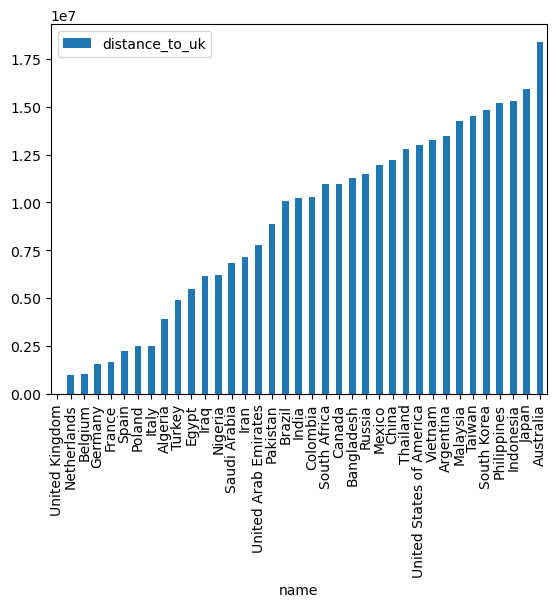

In [12]:
# Get only countries with GDP of >500K and plot on a bar chart
gdf_big = world_mercator[world_mercator['gdp_md_est'] > 500000]
gdf_big = gdf_big.sort_values('distance_to_uk')
gdf_big.plot.bar(x='name', y='distance_to_uk')

# Writing to file

You can write either as a shapefile or GeoJSON file 

In [ ]:
gdf_big[['name','geometry','distance_to_uk']].to_file('../assets/big_countries.geojson',
                                                      driver='GeoJSON')

In [ ]:
gdf_big[['name','geometry','distance_to_uk']].to_file('../assets/big_countries.shp')

### Exercise 4
> We are now switching from these global datasets to more regional data. We are going to plan our next holiday or weekend trip in the UK!
> There are a lot of amazing and freely available vector data sets for the UK available. I put a couple of them in the "assets/UK_shapefiles" directory, but feel free to add more datasets if you like. So let's make our own little map to decide where we want to spend our next free weekend!
> - we want to enjoy the beautiful UK countryside, so let's start by loading the shapefiles for the [Areas of Outstanding Natural Beauty (AONBs)](https://landscapesforlife.org.uk/about-aonbs/aonbs/overview) and the [UK Nationakl Parks](https://www.nationalparks.uk/parks/) (the data is already downloaded)
    - load them with `geopandas`, analyse the shapes, dimensions, projection, and attributes and plot all regions onto a single map
    - always make sure that all datasets use the same CRS (you can check it with the method .crs on any `geopandas`GeoDataFrame)
> - we need to get to those nice places somehow, so the next we use the [Strategi regional dataset](https://osdatahub.os.uk/downloads/open/Strategi) and load the railway lines and stations and add them to our map
    - feel free to add any other types of vector data to your map as well (e.g rivers, lakes, coastlines)
    - you can change the color, marker and linestyles with standard matplotlib syntax
> - the UK train network is not the best in the world, so maybe we don't want to go too far away, but rather look for a weekend trip in the South West of England
    - make a new map that just focuses on the South West region (you can use `ax.set_xlim` and `ax.set_ylim` to zoom in on any region)
> - because we are on a tight budget, we don't look for a fancy hotel, but rather want to take our backpacks and go wild camping
    - places for wild camping in England are hard to find, but your friend found this amazing shapefile ("camping_webmap") of places in the Dartmoor National Park where it is actually allowed
    - add the camping areas to your map and zoom into the Dartmoor National Park
    - looks like there is a trainline right towards the northern end that brings us all the way to the camping area!
    - but what is this station or town where we want to go called?

In [77]:
# Write your exercise code here.
aonb = gpd.read_file("../assets/UK_shapefiles/NE_AreasOfOutstandingNaturalBeautyEngland_SHP_Full/data/Areas_of_Outstanding_Natural_Beauty_England.shp")
uk_np = gpd.read_file("../assets/UK_shapefiles/NE_NationalParksEngland_SHP_Full/data/National_Parks_England.shp")
uk_rail = gpd.read_file("../assets/UK_shapefiles/strtgi_essh_gb/data/railway_line.shp")
uk_stations = gpd.read_file("../assets/UK_shapefiles/strtgi_essh_gb/data/railway_point.shp")
camp_areas = gpd.read_file("../assets/UK_shapefiles/camping_webmap/camping_webmap.shp")
coastline = gpd.read_file("../assets/UK_shapefiles/strtgi_essh_gb/data/coastline.shp")
lakes = gpd.read_file("../assets/UK_shapefiles/strtgi_essh_gb/data/lakes_region.shp")
rivers = gpd.read_file("../assets/UK_shapefiles/strtgi_essh_gb/data/rivers_line.shp")

In [60]:
uk_rail

,CODE,LEGEND,AMENDED,geometry
0,5511,"Railway, Standard Gauge over other feature",1997-07-22,"LINESTRING (361988 132626, 362190 132770, 3622..."
1,5511,"Railway, Standard Gauge over other feature",1993-01-01,"LINESTRING (436069 121426, 436406 121393, 4364..."
2,5511,"Railway, Standard Gauge over other feature",1993-01-01,"LINESTRING (567735 146104, 567689 145816, 5676..."
3,5511,"Railway, Standard Gauge over other feature",1993-01-01,"LINESTRING (609245 232118, 609470 232180, 6095..."
4,5513,"Railway, Narrow Gauge over other feature",1994-04-19,"LINESTRING (257962 358911, 258043 358820, 2580..."
...,...,...,...,...
13595,5510,"Railway, Standard Gauge",2002-01-23,"LINESTRING (450380 212226, 450800 212800, 4518..."
13596,5510,"Railway, Standard Gauge",1997-04-16,"LINESTRING (459602 222471, 459704 222423)"
13597,5510,"Railway, Standard Gauge",2014-09-05,"LINESTRING (458727 222007, 459025 222247, 4592..."
13598,5510,"Railway, Standard Gauge",2015-10-16,"LINESTRING (459936 222314, 459704 222423)"


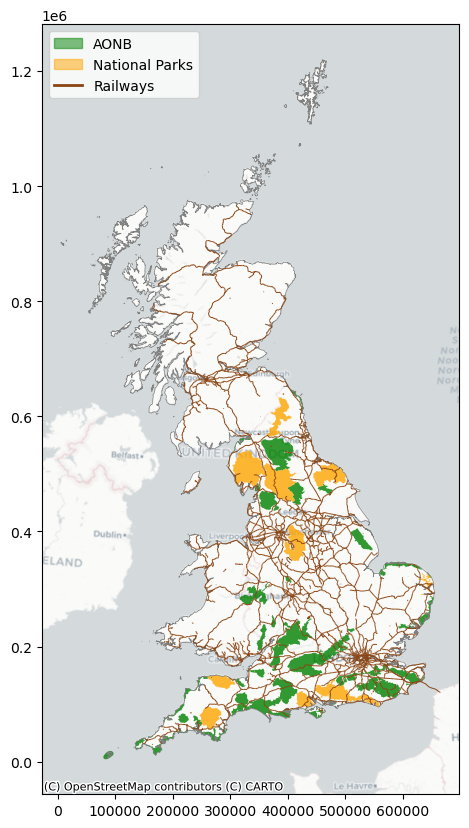

In [91]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import contextily as cx

fig, ax = plt.subplots(figsize=(14,10))
coastline.plot(ax=ax, color='grey', lw=0.5)
aonb.plot(ax=ax, color='green', alpha=0.8)
uk_np.plot(ax=ax, color='orange', alpha=0.8)
uk_rail.plot(ax=ax, color='saddlebrown', lw=0.7)
#uk_stations.plot(ax=ax, color='red', marker='*', markersize=10)

cx.add_basemap(ax, crs=aonb.crs, source=cx.providers.CartoDB.Positron)

legend_elements = [
    Patch(color='green', label='AONB', alpha=0.5),
    Patch(color='orange', label='National Parks', alpha=0.5),
    Line2D([0], [0], color='saddlebrown', lw=2, label='Railways'),
    #Line2D([0], [0], marker='*', color='red', markersize=10, linestyle='', label='Stations')
]

# Add the legend
ax.legend(handles=legend_elements, loc='upper left');

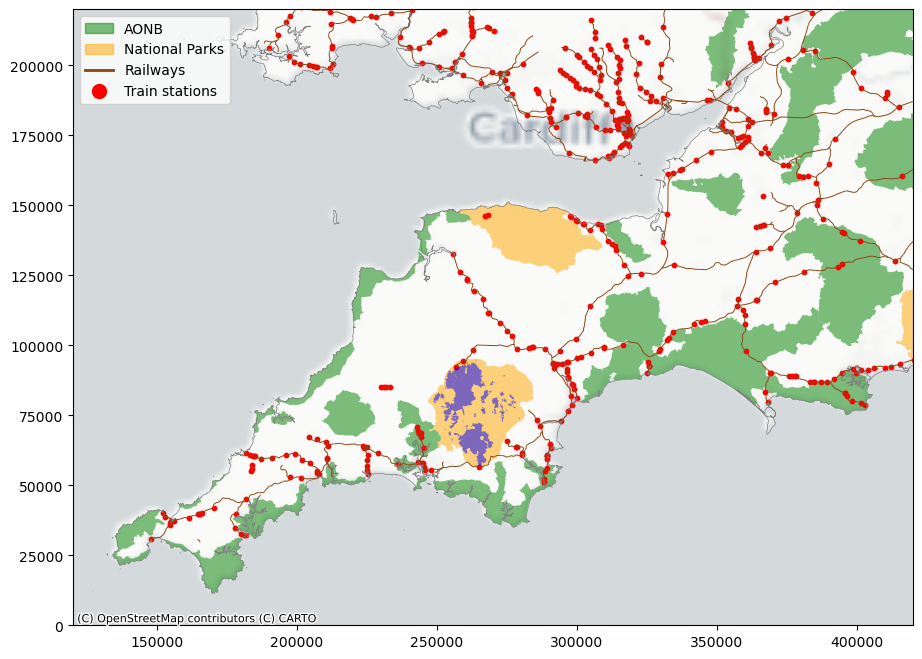

In [95]:
# zooming in to the south west
fig, ax = plt.subplots(figsize=(12,8))
coastline.plot(ax=ax, color='grey', lw=0.5)
aonb.plot(ax=ax, color='green', alpha=0.5)
uk_np.plot(ax=ax, color='orange', alpha=0.5)
uk_rail.plot(ax=ax, color='saddlebrown', lw=0.7)
uk_stations.plot(ax=ax, color='red', marker='o', markersize=10)
camp_areas.plot(ax=ax, color='blue', alpha=0.5)

cx.add_basemap(ax, crs=aonb.crs, source=cx.providers.CartoDB.Positron)

legend_elements = [
    Patch(color='green', label='AONB', alpha=0.5),
    Patch(color='orange', label='National Parks', alpha=0.5),
    Line2D([0], [0], color='saddlebrown', lw=2, label='Railways'),
    Line2D([0], [0], marker='o', color='red', markersize=10, linestyle='', label='Train stations')
]

# Add the legend
ax.legend(handles=legend_elements, loc='upper left');

ax.set_xlim([120000, 420000])
ax.set_ylim([0, 0.22e6]);

In [114]:
uk_stations

,CODE,LEGEND,AMENDED,NAME,ORIENT,geometry
0,5531,Level Crossing on Unclassified Road,1997-02-03,None,0.0,POINT (196068 60817)
1,5531,Level Crossing on Unclassified Road,2007-08-29,None,0.0,POINT (164899 39661)
2,5531,Level Crossing on Unclassified Road,1993-01-01,None,0.0,POINT (161374 38412)
3,5531,Level Crossing on Unclassified Road,1993-01-01,None,0.0,POINT (165910 40080)
4,5531,Level Crossing on Unclassified Road,2007-08-29,None,0.0,POINT (165267 39838)
...,...,...,...,...,...,...
4632,5520,Railway Station,2012-06-13,Ebbw Vale Parkway Station,0.0,POINT (317687 206985)
4633,5520,Railway Station,2015-08-17,Ebbow Vale Town Centre,0.0,POINT (317129 209199)
4634,5520,Railway Station,2015-09-08,Corwen Station,0.0,POINT (308386 343661)
4635,5520,Railway Station,2015-10-16,Oxford Parkway Station,0.0,POINT (450380 212226)


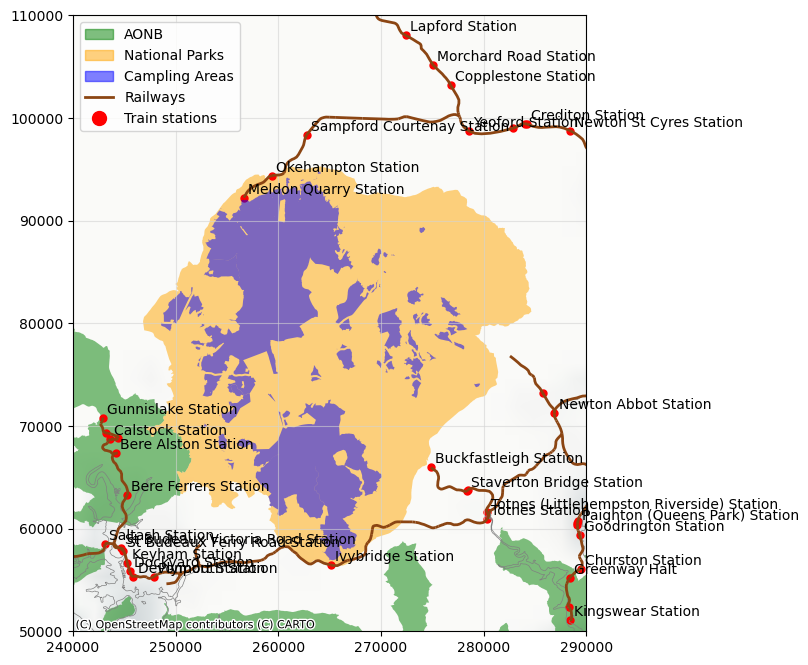

In [115]:
# zooming into dartmoor national park
fig, ax = plt.subplots(figsize=(12,8))
coastline.plot(ax=ax, color='grey', lw=0.5)
aonb.plot(ax=ax, color='green', alpha=0.5)
uk_np.plot(ax=ax, color='orange', alpha=0.5)
#rivers.plot(ax=ax, color='royalblue', lw=1, alpha=0.5)
uk_rail.plot(ax=ax, color='saddlebrown', lw=2)
uk_stations.plot(ax=ax, color='red', marker='o', markersize=25)
camp_areas.plot(ax=ax, color='blue', alpha=0.5)

for x, y, label in zip(uk_stations.geometry.x, uk_stations.geometry.y, uk_stations.NAME):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

cx.add_basemap(ax, crs=aonb.crs, source=cx.providers.CartoDB.PositronNoLabels)

legend_elements = [
    Patch(color='green', label='AONB', alpha=0.5),
    Patch(color='orange', label='National Parks', alpha=0.5),
    Patch(color='blue', label='Campling Areas', alpha=0.5),
    #Line2D([0], [0], color='royalblue', lw=1, label='Rivers'),
    Line2D([0], [0], color='saddlebrown', lw=2, label='Railways'),
    Line2D([0], [0], marker='o', color='red', markersize=10, linestyle='', label='Train stations')
]

# Add the legend
ax.legend(handles=legend_elements, loc='upper left');
ax.grid(True, color='lightgrey', alpha=0.6)


ax.set_xlim([240000, 290000])
ax.set_ylim([50000, 110000]);


**The station is called Meldon Quarry Station**

[<small>answer</small>](../solutions/UK_shapefiles.ipynb)

## [[Previous: Vector in geopandas](./02-vectors.ipynb)] | [[Next: Spatial relations and joins](./04-relation_join.ipynb)]